In [1]:
%matplotlib inline
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import warnings

In [23]:
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, ConstantSpatialModel
from gammapy.irf import EDispKernel, PSFMap, PSFKernel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion
from hawc_dataset import HAWCMapDataset
from itertools import combinations
from gammapy.visualization.utils import plot_contour_line
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
)
import matplotlib.patches as mpatches

#### hawc analysis

In [3]:
spatial_model_hawc = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model_hawc = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model_hawc.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model_hawc.beta.error = 0.015
spectral_model_hawc.alpha.error = 0.019

model_hawc = SkyModel(spatial_model=spatial_model_hawc, spectral_model=spectral_model_hawc, name='crab hawc')

In [4]:
%%time
datasets_hawc = []
for i in range(1,10):
    dataset =  HAWCMapDataset.read('gammapy_dataset_var_energy/hawc/crab-{}nHitBin.fits.gz'.format(i))
    dataset.models.append(model_hawc)
    dataset.background_model.spectral_model.norm.frozen = True
    datasets_hawc.append(dataset)

CPU times: user 51.7 s, sys: 1.3 s, total: 53 s
Wall time: 1min 8s


In [5]:
fit_hawc = Fit(datasets_hawc)

In [6]:
%%time
#minuit_opts = {"tol": 100, "strategy": 0}
#result_hawc = fit_hawc.run(backend="minuit", optimize_opts=minuit_opts)
result_hawc = fit_hawc.run()

CPU times: user 2min 30s, sys: 2.94 s, total: 2min 33s
Wall time: 2min 47s


In [7]:
result_hawc.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,norm,1.0000e+00,,nan,nan,True,0.000e+00
1,tilt,0.0000e+00,,nan,nan,True,0.000e+00
2,reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
3,amplitude,2.2585e-13,cm-2 s-1 TeV-1,nan,nan,False,3.652e-15
4,reference,7.0000e+00,TeV,nan,nan,True,0.000e+00
5,alpha,2.7758e+00,,nan,nan,False,1.653e-02
6,beta,8.8430e-02,,nan,nan,False,7.076e-03
7,lon_0,8.3632e+01,deg,nan,nan,False,1.998e-03
8,lat_0,2.2021e+01,deg,-9.000e+01,9.000e+01,False,1.532e-03
9,norm,1.0000e+00,,nan,nan,True,0.000e+00


#### hess analysis

In [9]:
spatial_model_hess = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model_hess = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model_hess.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model_hess.beta.error = 0.015
spectral_model_hess.alpha.error = 0.019

model_hess = SkyModel(spatial_model=spatial_model_hess, spectral_model=spectral_model_hess, name='crab hess')

In [10]:
datasets_hess = []
for i in range(5):
    dataset = MapDataset.read('/lfs/l2/hawc/users/vikasj78/gammapyData/crabCustomEBins/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(i))
    dataset.models.append(model_hess)
    datasets_hess.append(dataset)

In [11]:
fit_hess = Fit(datasets_hess)

In [12]:
%%time
result_hess = fit_hess.run()

CPU times: user 41.6 s, sys: 55 ms, total: 41.7 s
Wall time: 44.1 s


#### joint analysis

In [13]:
spatial_model_joint = PointSpatialModel(
    lon_0="83.63 deg",
    lat_0="22.01 deg",
    frame="icrs"
)

spectral_model_joint = LogParabolaSpectralModel(
        amplitude="2.6e-13 TeV-1 cm-2 s-1",
        alpha=2.65,
        beta=0.1,
        reference="7 TeV"
)

spectral_model_joint.amplitude.error = "0.07e-13 TeV-1 cm-2 s-1"
spectral_model_joint.beta.error = 0.015
spectral_model_joint.alpha.error = 0.019

model_joint = SkyModel(spatial_model=spatial_model_joint, spectral_model=spectral_model_joint, name='crab joint')

In [14]:
datasets_joint = []
for i in range(1,10):
    dataset =  HAWCMapDataset.read('gammapy_dataset_var_energy/hawc/crab-{}nHitBin.fits.gz'.format(i))
    dataset.models.append(model_joint)
    dataset.background_model.spectral_model.norm.frozen = True
    datasets_joint.append(dataset)
for i in range(5):
    dataset = MapDataset.read('/lfs/l2/hawc/users/vikasj78/gammapyData/crabCustomEBins/dataset-bkg-fit-stacked-thresh-{:02d}.fits.gz'.format(i))
    dataset.models.append(model_joint)
    datasets_joint.append(dataset)

In [15]:
fit_joint = Fit(datasets_joint)

In [16]:
%%time
#minuit_opts = {"tol": 1.0, "strategy": 2}
#result_joint = fit_joint.run(backend="minuit", optimize_opts=minuit_opts)
result_joint = fit_joint.run()

CPU times: user 5min 24s, sys: 49.3 s, total: 6min 13s
Wall time: 6min 14s


#### plotting spectrum for check if everything worked fine

In [17]:
#Energy Estimators
ref_model_energy = LogParabolaSpectralModel(
    amplitude="2.35e-13 TeV-1 cm-2 s-1",
    alpha=2.79,
    beta=0.10,
    reference="7 TeV"
)

ref_model_energy.amplitude.error = "0.04e-13 TeV-1 cm-2 s-1"
ref_model_energy.beta.error = 0.02
ref_model_energy.alpha.error = 0.01

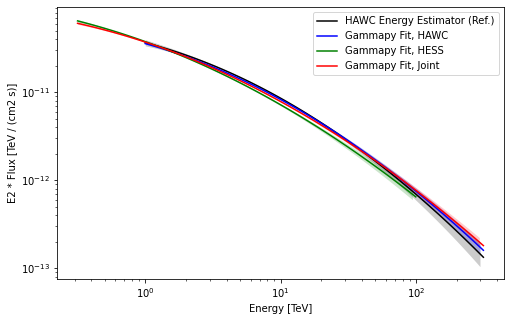

In [19]:
plt.figure(figsize=(8, 5))
ax = ref_model_energy.plot(energy_range=(1, 316) * u.TeV, energy_power=2, label="HAWC Energy Estimator (Ref.)", color='black')
ref_model_energy.plot_error(energy_range=(1, 316) * u.TeV, energy_power=2, ax=ax, color='black')
spectral_model_hawc.plot(ax=ax, energy_range=(1, 316) * u.TeV, energy_power=2, label="Gammapy Fit, HAWC", color='blue')
spectral_model_hawc.plot_error(ax=ax, energy_range=(1, 316) * u.TeV, energy_power=2, color='blue')
spectral_model_hess.plot(ax=ax, energy_range=(0.316, 100) * u.TeV, energy_power=2, label="Gammapy Fit, HESS", color='green')
spectral_model_hess.plot_error(ax=ax, energy_range=(0.316, 100) * u.TeV, energy_power=2, color='green')
spectral_model_joint.plot(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, label="Gammapy Fit, Joint", color='red')
spectral_model_joint.plot_error(ax=ax, energy_range=(0.316, 316) * u.TeV, energy_power=2, color='red')
plt.legend()
plt.savefig("plotsCustomEbins/hess_hawc_joint_fit_without_flux_points_all.png", dpi=300, bbox_inches='tight')

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: invalid value encountered in true_divide
  np.true_divide(values, self.vmax - self.vmin, out=values)
/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/astropy/visualization/mpl_normalize.py:130: RuntimeWarning: inval

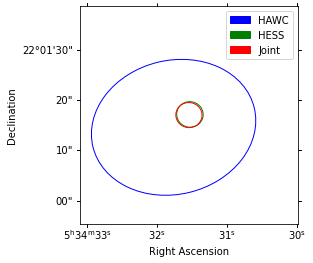

In [28]:
handles = []
geom = WcsGeom.create(
    skydir=(spatial_model_joint.position),
    binsz=0.001,
    width=(0.012, 0.012),
    frame="icrs",
    proj="CAR",
)
model = ConstantSpatialModel()
ax = model.plot(geom=geom)
models = [spatial_model_hawc,spatial_model_hess,spatial_model_joint]
colors = ['blue','green','red']
names = ['HAWC','HESS','Joint']
for model, name, color in zip(models, names, colors):
    region = model.position_error.to_pixel(ax.wcs)
    artist = region.as_artist(facecolor="none", edgecolor=color)
    handle = mpatches.Patch(label=name, color=color)
    handles.append(handle)
    ax.add_artist(artist)
plt.legend(handles=handles)
plt.savefig("plotsCustomEbins/source_positions.png", dpi=300, bbox_inches='tight')

In [29]:
result_hawc.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,norm,1.0000e+00,,nan,nan,True,0.000e+00
1,tilt,0.0000e+00,,nan,nan,True,0.000e+00
2,reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
3,amplitude,2.2585e-13,cm-2 s-1 TeV-1,nan,nan,False,3.652e-15
4,reference,7.0000e+00,TeV,nan,nan,True,0.000e+00
5,alpha,2.7758e+00,,nan,nan,False,1.653e-02
6,beta,8.8430e-02,,nan,nan,False,7.076e-03
7,lon_0,8.3632e+01,deg,nan,nan,False,1.998e-03
8,lat_0,2.2021e+01,deg,-9.000e+01,9.000e+01,False,1.532e-03
9,norm,1.0000e+00,,nan,nan,True,0.000e+00


In [30]:
result_hess.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,norm,9.9650e-01,,nan,nan,False,2.094e-02
1,tilt,0.0000e+00,,nan,nan,True,0.000e+00
2,reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
3,amplitude,2.0002e-13,cm-2 s-1 TeV-1,nan,nan,False,3.772e-15
4,reference,7.0000e+00,TeV,nan,nan,True,0.000e+00
5,alpha,2.8318e+00,,nan,nan,False,2.411e-02
6,beta,7.1598e-02,,nan,nan,False,9.688e-03
7,lon_0,8.3631e+01,deg,nan,nan,False,3.219e-04
8,lat_0,2.2021e+01,deg,-9.000e+01,9.000e+01,False,2.877e-04
9,norm,1.0035e+00,,nan,nan,False,6.961e-03


In [31]:
result_joint.parameters.to_table().show_in_notebook()

idx,name,value,unit,min,max,frozen,error
0,norm,1.0000e+00,,nan,nan,True,0.000e+00
1,tilt,0.0000e+00,,nan,nan,True,0.000e+00
2,reference,1.0000e+00,TeV,nan,nan,True,0.000e+00
3,amplitude,2.1476e-13,cm-2 s-1 TeV-1,nan,nan,False,2.628e-15
4,reference,7.0000e+00,TeV,nan,nan,True,0.000e+00
5,alpha,2.7911e+00,,nan,nan,False,1.372e-02
6,beta,7.2478e-02,,nan,nan,False,5.429e-03
7,lon_0,8.3631e+01,deg,nan,nan,False,3.182e-04
8,lat_0,2.2021e+01,deg,-9.000e+01,9.000e+01,False,2.827e-04
9,norm,1.0000e+00,,nan,nan,True,0.000e+00


In [35]:
def make_contours(fit, result, par1, par2, x_values, y_values):
    optimize_opts = {"backend": "minuit", "print_level": 0}
    x = result.parameters[par1]
    y = result.parameters[par2]
    stat_surface = fit.stat_surface(
        x, y, x_values, y_values, reoptimize=False, **optimize_opts
    )
    # Compute TS
    TS = stat_surface["stat_scan"] - result.total_stat
    # Compute the corresponding statistical significance surface
    gaussian_sigmas = np.sqrt(TS.T)
    return gaussian_sigmas

In [44]:
%%time
x_values = np.linspace(0.06, 0.10, 50)
y_values = np.linspace(1.9e-13, 2.3e-13, 50)
par1 = 'beta'
par2 = 'amplitude'
fits = [fit_hawc, fit_hess, fit_joint]
results = [result_hawc, result_hess, result_joint]
names = ['hawc','hess','joint']
for fit,result,name in zip(fits,results,names):
    gaussian_sigma = make_contours(fit,result,par1,par2,x_values,y_values)
    file_name = name + '_' + par1 + '_' + par2 + '.npz'
    np.savez('contoursDataFull/'+file_name,sigmas=gaussian_sigma)

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 1h 22min 6s, sys: 8min 27s, total: 1h 30min 33s
Wall time: 1h 30min 53s


/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


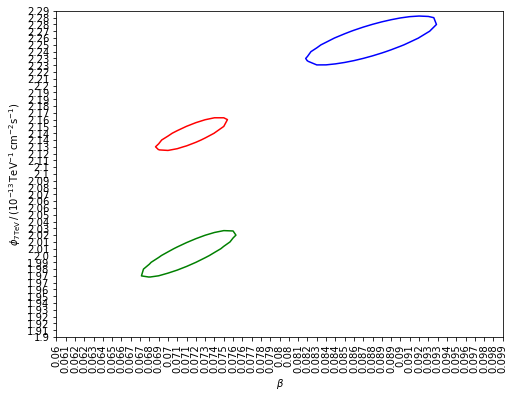

In [54]:
x_values = np.linspace(0.06, 0.10, 50)
y_values = np.linspace(1.9e-13, 2.3e-13, 50)
par1 = 'beta'
par2 = 'amplitude'
names = ['hawc','hess','joint']
colors = ['blue','green','red']
x1 = 0; x2 = -1; y1 = 0; y2 = -1
fig, ax = plt.subplots(figsize=(8, 6))
for name, color in zip(names,colors):
    data = np.load("contoursDataFull/{}_{}_{}.npz".format(name,par1,par2))
    data = data['sigmas']
    data = data[y1:y2,x1:x2]
    contours = plt.contour(data, levels=[1], colors=color)
    #plt.clabel(contours, fmt=name, inline=3, fontsize=15)
plt.xticks(range(len(x_values[x1:x2])), np.around(x_values[x1:x2], decimals=3), rotation=90)
plt.yticks(range(len(y_values[y1:y2])), np.around(y_values[y1:y2]*1e13,decimals=2));
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\phi_{\rm 7 TeV} \,/\,(10^{-13}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$")
plt.savefig("plotsCustomEbins/contours_beta_amplitude.png", dpi=300, bbox_inches='tight')

In [53]:
%%time
x_values = np.linspace(2.7, 2.9, 50)
y_values = np.linspace(0.06, 0.10, 50)
par1 = 'alpha'
par2 = 'beta'
fits = [fit_hawc, fit_hess, fit_joint]
results = [result_hawc, result_hess, result_joint]
names = ['hawc','hess','joint']
for fit,result,name in zip(fits,results,names):
    gaussian_sigma = make_contours(fit,result,par1,par2,x_values,y_values)
    file_name = name + '_' + par1 + '_' + par2 + '.npz'
    np.savez('contoursDataFull/'+file_name,sigmas=gaussian_sigma)

/lfs/l2/hawc/users/vikasj78/software-hess/gammapy_latest/anaconda3/envs/gammapy-0.17/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in sqrt
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 1h 6min 27s, sys: 10min 56s, total: 1h 17min 23s
Wall time: 1h 18min 7s


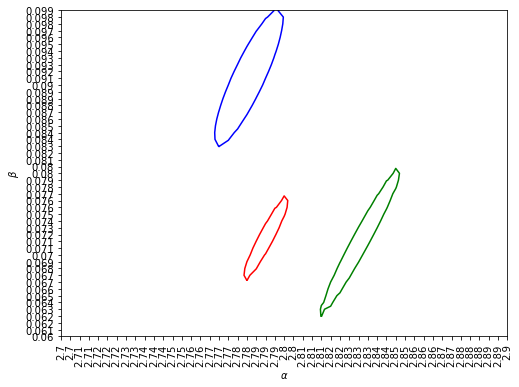

In [56]:
x_values = np.linspace(2.7, 2.9, 50)
y_values = np.linspace(0.06, 0.10, 50)
par1 = 'alpha'
par2 = 'beta'
names = ['hawc','hess','joint']
colors = ['blue','green','red']
x1 = 0; x2 = -1; y1 = 0; y2 = -1
fig, ax = plt.subplots(figsize=(8, 6))
for name, color in zip(names,colors):
    data = np.load("contoursDataFull/{}_{}_{}.npz".format(name,par1,par2))
    data = data['sigmas']
    data = data[y1:y2,x1:x2]
    contours = plt.contour(data, levels=[1], colors=color)
    #plt.clabel(contours, fmt=name, inline=3, fontsize=15)
plt.xticks(range(len(x_values[x1:x2])), np.around(x_values[x1:x2], decimals=2), rotation=90)
plt.yticks(range(len(y_values[y1:y2])), np.around(y_values[y1:y2], decimals=3));
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\beta$")
plt.savefig("plotsCustomEbins/contours_alpha_beta.png", dpi=300, bbox_inches='tight')

In [ ]:
%%time
x_values = np.linspace(2.7, 2.9, 50)
y_values = np.linspace(1.9e-13, 2.3e-13, 50)
par1 = 'alpha'
par2 = 'amplitude'
fits = [fit_hawc, fit_hess, fit_joint]
results = [result_hawc, result_hess, result_joint]
names = ['hawc','hess','joint']
for fit,result,name in zip(fits,results,names):
    gaussian_sigma = make_contours(fit,result,par1,par2,x_values,y_values)
    file_name = name + '_' + par1 + '_' + par2 + '.npz'
    np.savez('contoursDataFull/'+file_name,sigmas=gaussian_sigma)

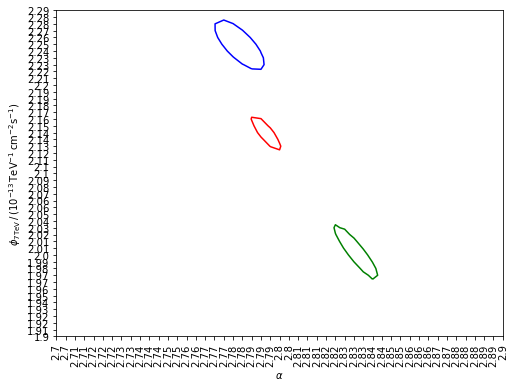

In [59]:
x_values = np.linspace(2.7, 2.9, 50)
y_values = np.linspace(1.9e-13, 2.3e-13, 50)
par1 = 'alpha'
par2 = 'amplitude'
names = ['hawc','hess','joint']
colors = ['blue','green','red']
x1 = 0; x2 = -1; y1 = 0; y2 = -1
fig, ax = plt.subplots(figsize=(8, 6))
for name, color in zip(names,colors):
    data = np.load("contoursDataFull/{}_{}_{}.npz".format(name,par1,par2))
    data = data['sigmas']
    data = data[y1:y2,x1:x2]
    contours = plt.contour(data, levels=[1], colors=color)
    #plt.clabel(contours, fmt=name, inline=3, fontsize=15)
plt.xticks(range(len(x_values[x1:x2])), np.around(x_values[x1:x2], decimals=2), rotation=90)
plt.yticks(range(len(y_values[y1:y2])), np.around(y_values[y1:y2]*1e13,decimals=2));
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\phi_{\rm 7 TeV} \,/\,(10^{-13}\,{\rm TeV}^{-1} \, {\rm cm}^{-2} {\rm s}^{-1})$")
plt.savefig("plotsCustomEbins/contours_alpha_amplitude.png", dpi=300, bbox_inches='tight')